# Using Muldoon

Here are some examples for how to use some of the functionality of Muldoon.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal

from muldoon.met_timeseries import MetTimeseries, PressureTimeseries, TemperatureTimeseries
from muldoon.utils import modified_lorentzian, fit_vortex, write_out_plot_data
from muldoon.read_data import *

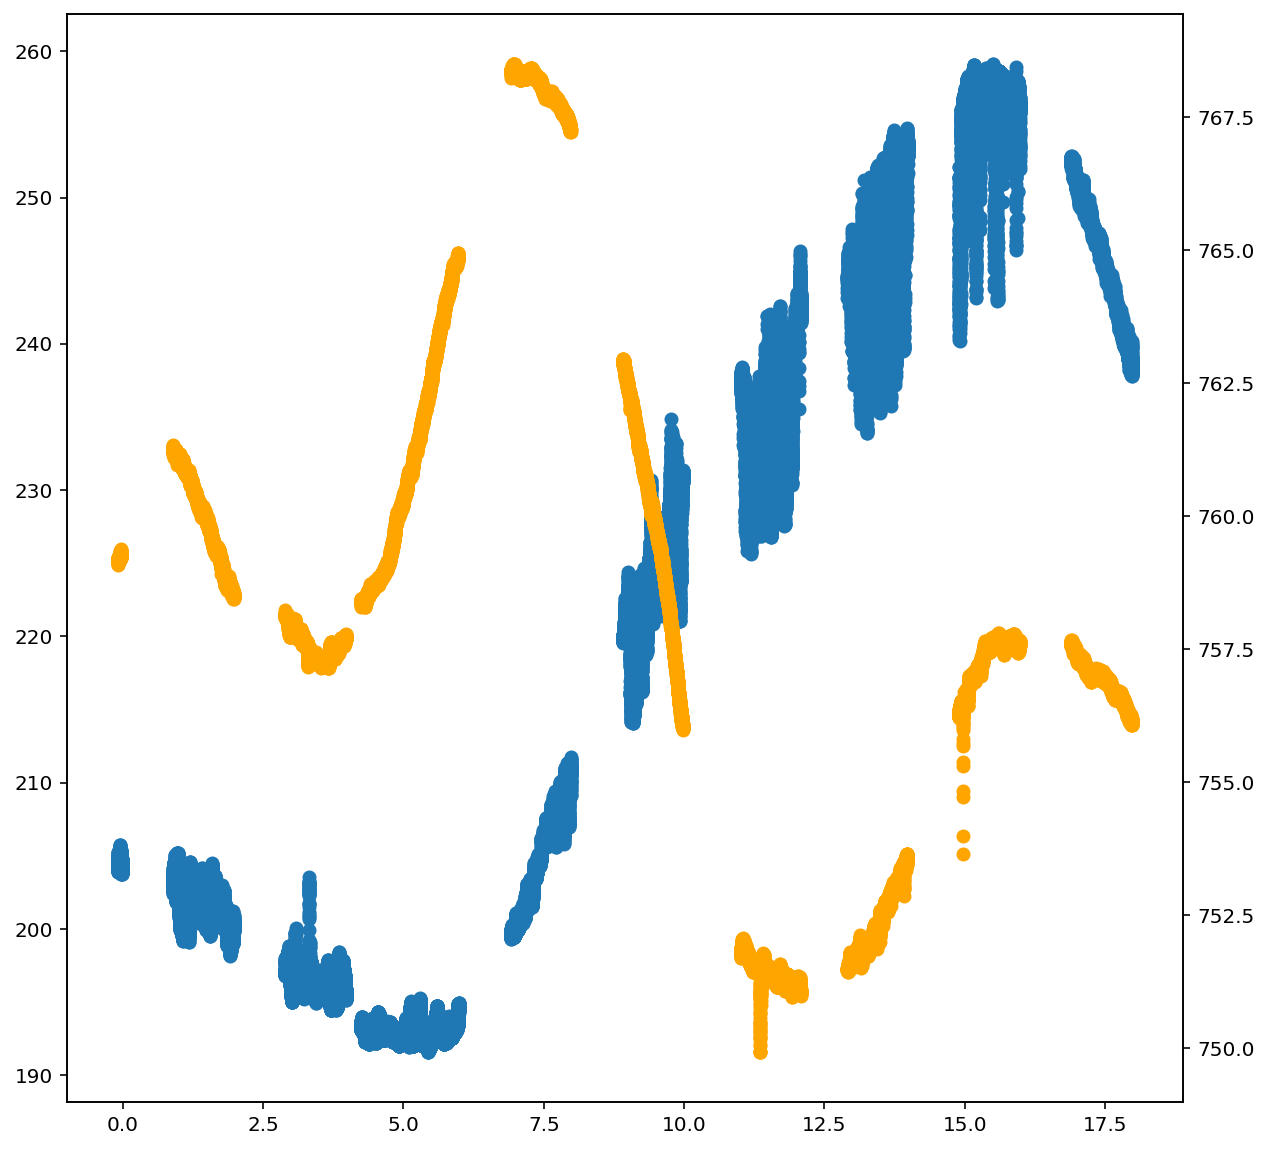

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

# How to read in data

# Temperature data
filename="WE__0089___________CAL_ATS_________________P01.CSV"
time, temperature = read_Perseverance_ATS_data(filename, which_ATS=1)
ax.scatter(time, temperature)

# Pressure data
filename="WE__0089___________DER_PS__________________P01.CSV"
time, temperature = read_Perseverance_PS_data(filename)
ax2.scatter(time, temperature, color='orange')

In [2]:
# Create time-series
time = np.linspace(-10, 10, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.5

right_answer = np.array([baseline, slope, t0, DeltaP, Gamma])

profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/20., size=len(time))
mt = PressureTimeseries(time, profile)

0.05407976270161954
True


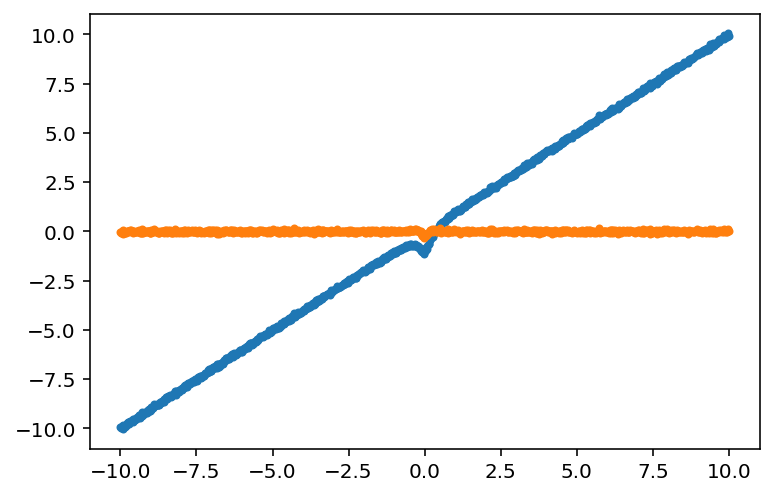

In [3]:
# Detrend
window_size = Gamma
detrended_pressure = mt.detrend_timeseries_boxcar(window_size)
print(np.std(mt.detrended_data))
print(np.isclose(np.std(mt.detrended_data), 0.1, atol=0.1))

plt.scatter(mt.time, mt.data, marker='.')
plt.scatter(mt.time, mt.detrended_data, marker='.')

In [4]:
# Test time-series write-out
write_str = write_out_plot_data(mt.time, mt.data, yerr=np.std(mt.data)*np.ones_like(mt.data),
                                x_label="Time", y_label="Pressure", test_mode=True)

10.999498189336935 0.010010010010010006 0.040040040040040026
0.010010010010010006


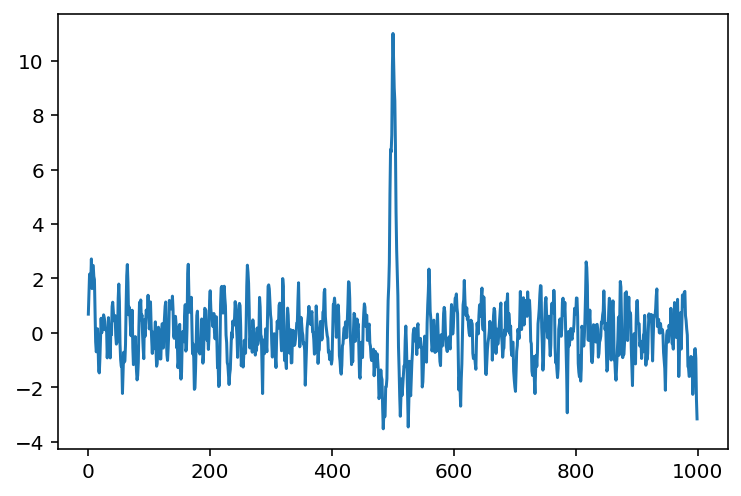

In [4]:
# plt.plot(mt.time, profile)
conv = mt.apply_lorentzian_matched_filter(2.*mt.sampling, 1./np.pi)
mx_ind = np.argmax(mt.convolution)

print(mt.convolution[mx_ind], np.abs(mt.time[mx_ind]), 2.*mt.sampling)
# plt.plot(mt.time, mt.convolution)
# plt.plot(mt.time, profile)
plt.plot(mt.convolution)
# Make sure convolution returns a strong peak at the right time
print((np.abs(mt.time[mx_ind])))

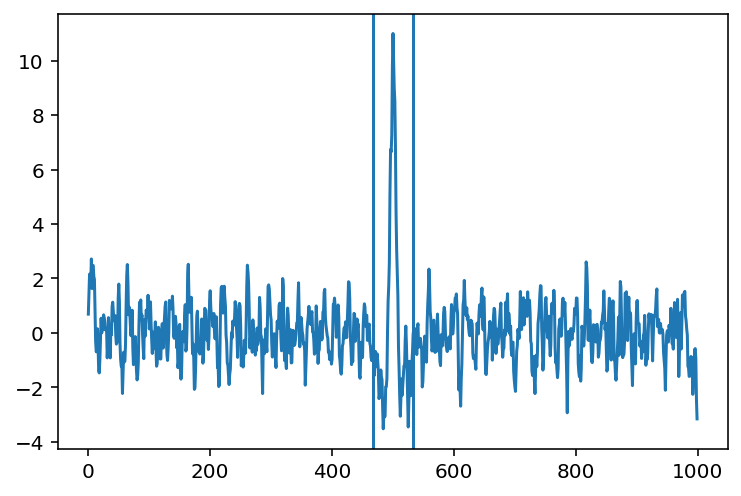

In [5]:
# Test find_vortices - Set the threshold very low to make sure the right peak is actually at the top of the list
vortices = mt.find_vortices(detection_threshold=2)
plt.plot(mt.convolution)
plt.axvline(mt.peak_indices[0] - 3.*mt.peak_widths[0])
plt.axvline(mt.peak_indices[0] + 3.*mt.peak_widths[0])

# Make sure the max peak in the convolution is the right one
assert(mt.time[mt.peak_indices[0]] < Gamma)

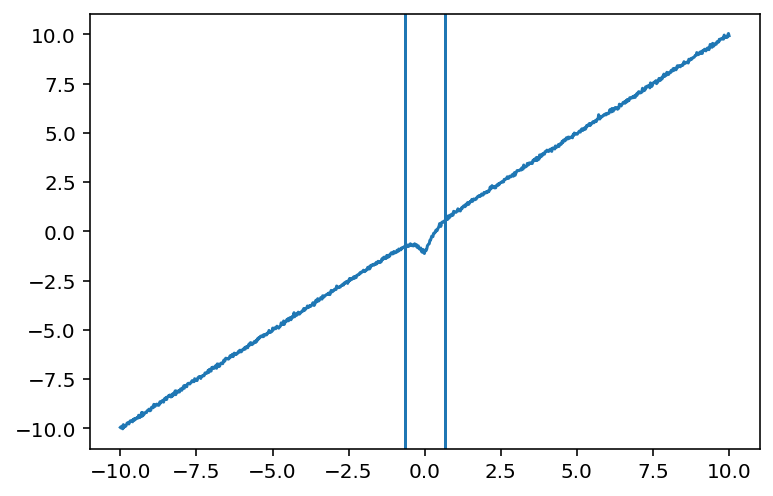

In [6]:
# Test find_vortices
vortices = mt.find_vortices(detection_threshold=7)
plt.plot(mt.time, mt.data)
plt.axvline(mt.time[mt.peak_indices[0] - 3*int(mt.peak_widths[0])])
plt.axvline(mt.time[mt.peak_indices[0] + 3*int(mt.peak_widths[0])])

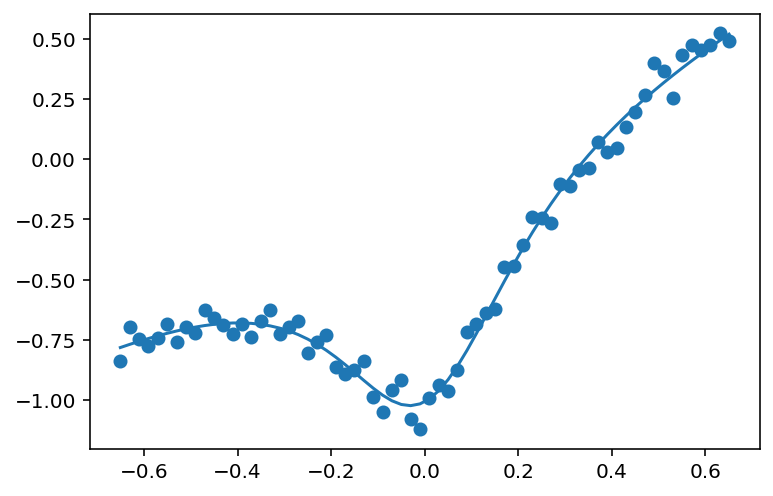

In [7]:
plt.scatter(vortices[0]["time"], vortices[0]["pressure"])

# Test vortex fit
old_popt, old_unc = fit_vortex(vortices[0], [0., 1., 0., 1., 0.01], 
                          [[-1, -1, np.min(vortices[0]["time"]), 0, 0],
                           [1, 1, np.max(vortices[0]["time"]), 2, 1]], sigma=vortices[0]["pressure_scatter"])
assert(np.max(np.abs(old_popt - right_answer)/old_unc) < 3.)

plt.plot(vortices[0]["time"], modified_lorentzian(vortices[0]["time"], *old_popt))

In [8]:
init_params = mt._determine_init_params(vortices[0])
bounds = mt._determine_bounds(vortices[0], init_params)
popt, unc = fit_vortex(vortices[0], init_params, bounds, sigma=vortices[0]["pressure_scatter"])
assert(np.max(np.abs(popt - right_answer)/unc) < 3.)

print(np.max(np.abs(popt - right_answer)/unc))

0.5188781676098949


In [10]:
# Test fit all vortices

# Create time-series
time = np.linspace(-10, 10, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.5

right_answer = np.array([baseline, slope, t0, DeltaP, Gamma])

profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/20., size=len(time))
mt = PressureTimeseries(time, profile)
window_size = Gamma
detrended_pressure = mt.detrend_timeseries_boxcar(window_size)

conv = mt.apply_lorentzian_matched_filter(2.*mt.sampling, 1./np.pi)
vortices = mt.find_vortices(detection_threshold=7)

popts, uncs = mt.fit_all_vortices()
print(np.max(np.abs(popts[0] - right_answer)/uncs[0]))
assert(np.max(np.abs(popts[0] - right_answer)/uncs[0]) < 5.)

2.2961274676151553


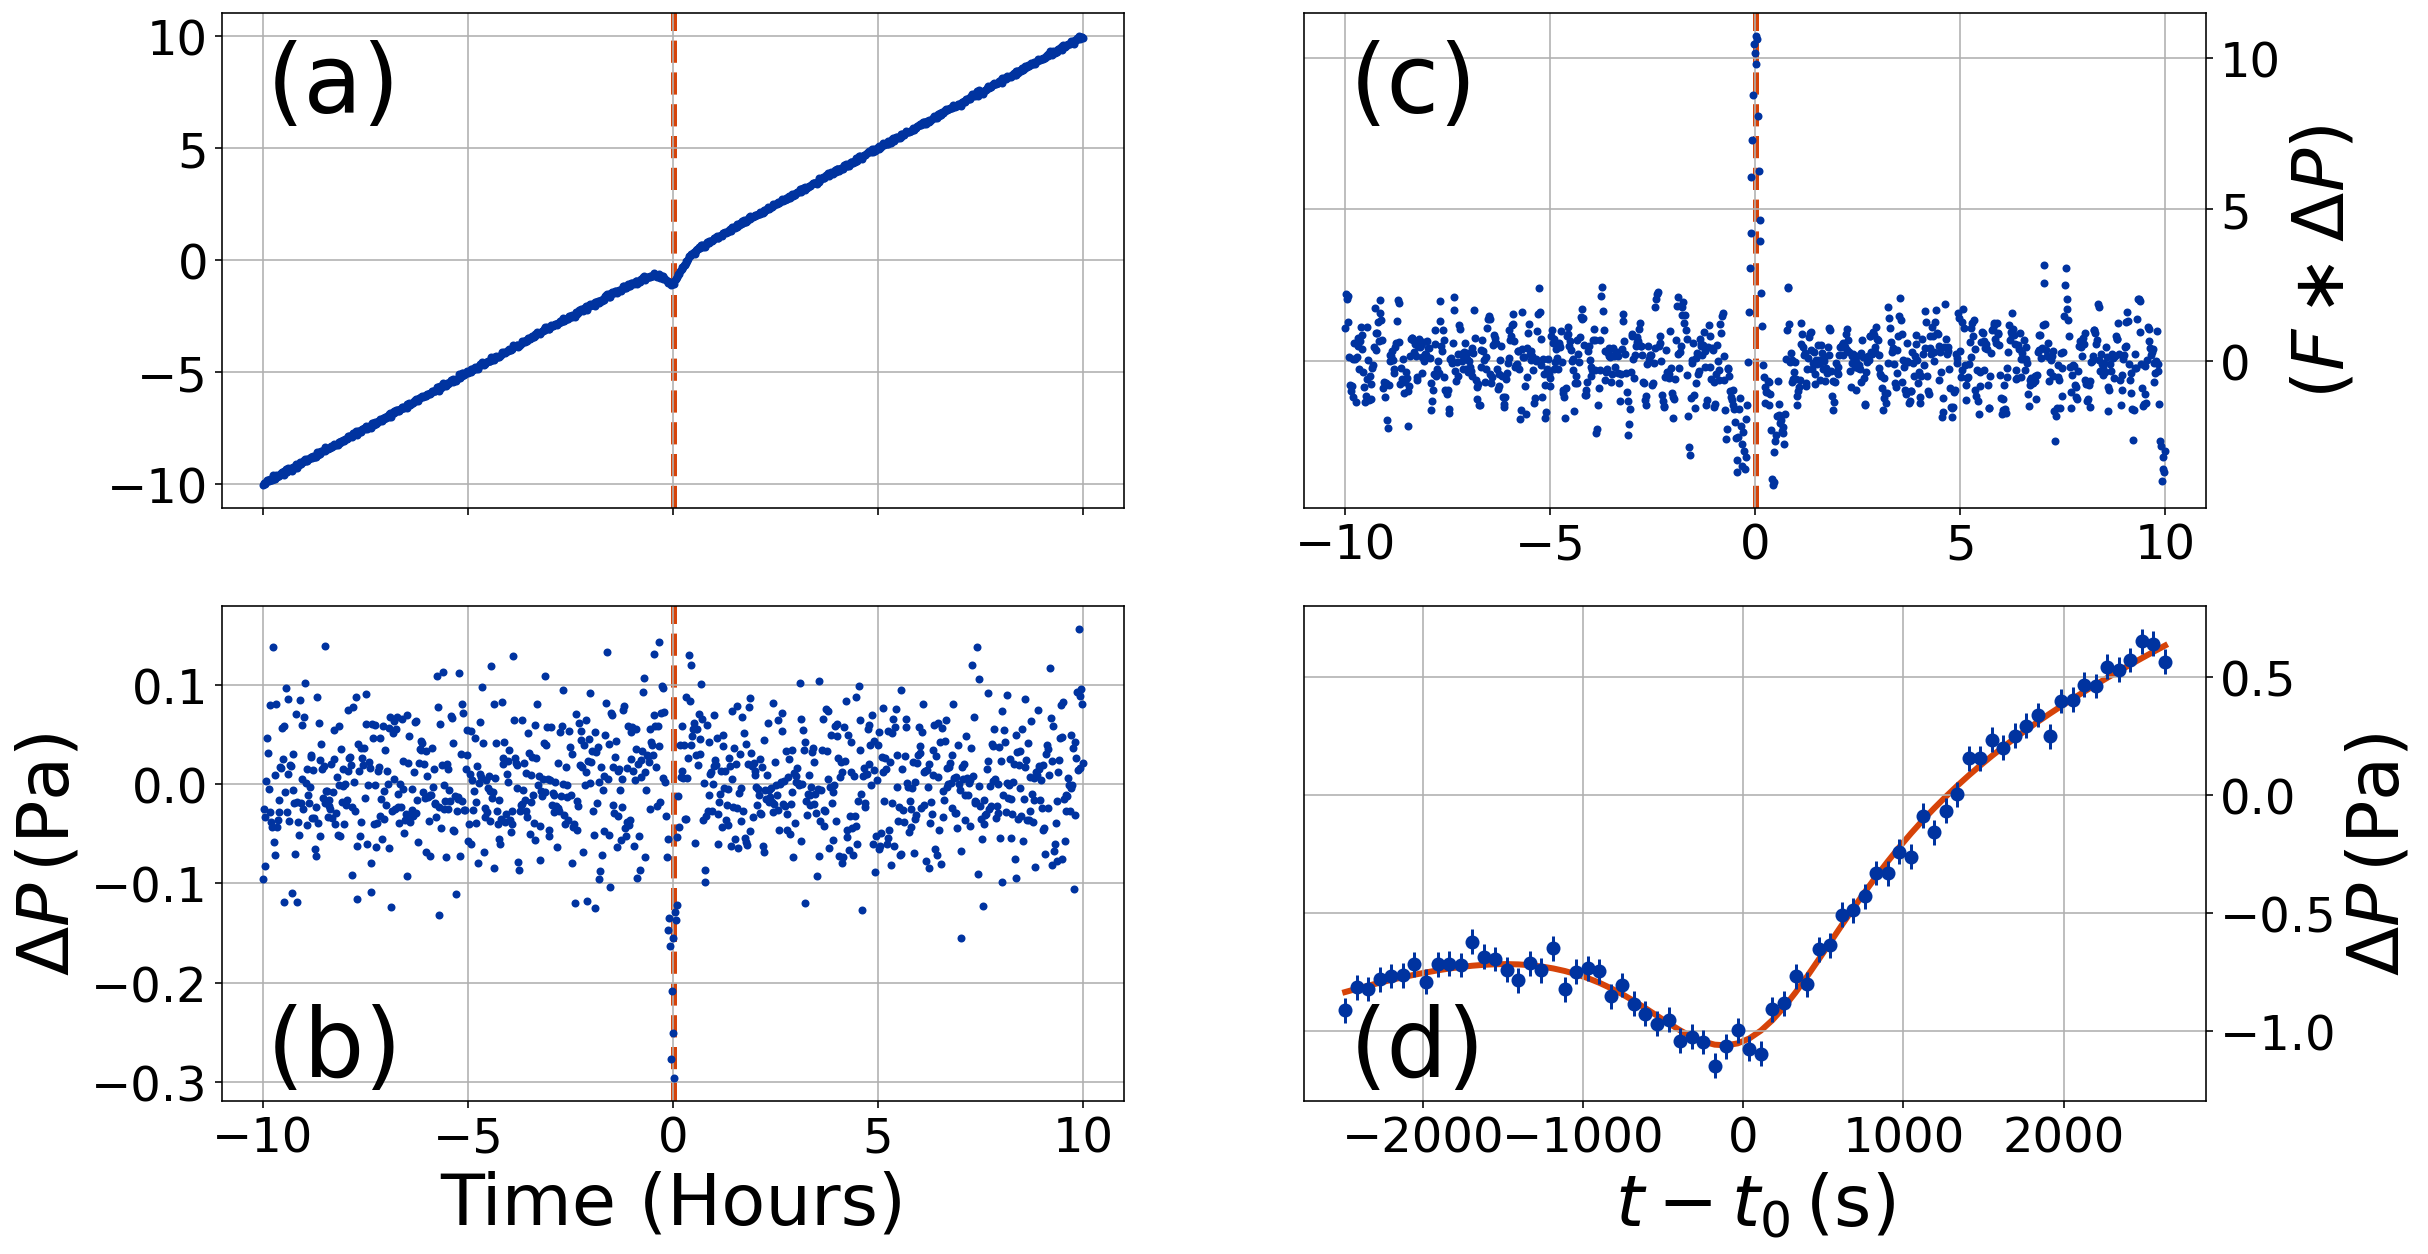

In [11]:
# Make plot showing how the data are conditioned and write out the data in each panel
mt.make_conditioned_data_figure(write_filename="./test_");

In [ ]:
# Generating synthetic temperature signal


---
Using the TemperatureTimeseries Class

In [25]:
# Temperature data
filename="WE__0089___________CAL_ATS_________________P01.CSV"

In [29]:
# Correct read_data to allow for sub-second sampling rates
times = make_seconds_since_midnight(filename)
print(times)

['23:54:25' '23:54:26' '23:54:26' ... '17:58:59' '17:59:00' '17:59:00']
[-0.09305556 -0.09277778 -0.09277778 ... 17.98305556 17.98333333
 17.98333333]


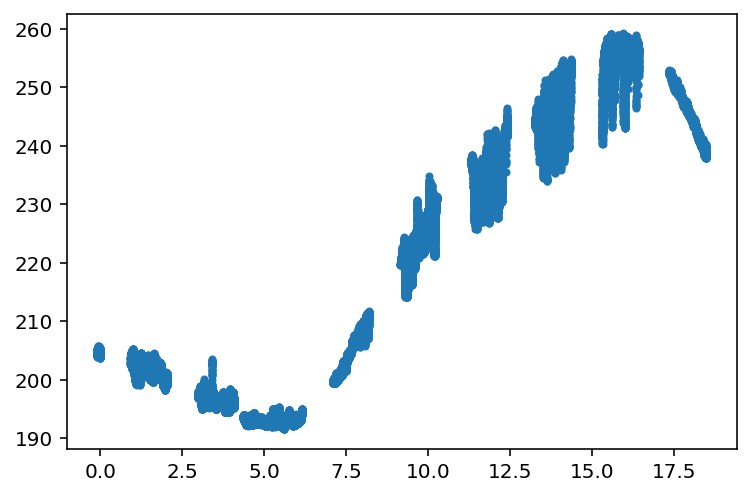

In [39]:
time, temperature = read_Perseverance_ATS_data(filename, which_ATS=1)
tt = TemperatureTimeseries(time, temperature)

plt.scatter(tt.time, tt.data, marker='.')

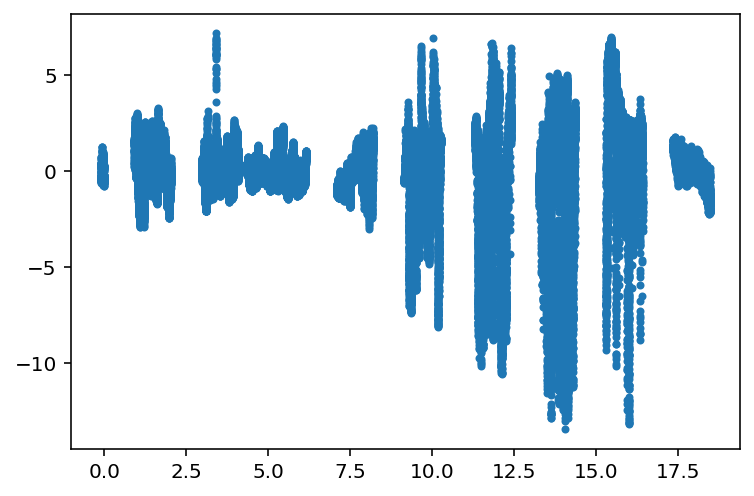

In [42]:
# Detrend
window_size = 1. # 1 hour
detrended_temperature = tt.detrend_timeseries_boxcar(window_size)
plt.scatter(tt.time, tt.detrended_data, marker='.')
